Verification au service pour Batiment 

In [1]:
import math
import pandas as pd

# Calcul de la flèche instantanée
def calcul_fleche_instantanee(qEd, L, E, I):
    return (5 * qEd * L**4) / (384 * E * I)

# Calcul de la flèche totale avec fluage
def calcul_fleche_totale(w_el, phi):
    return w_el * (1 + phi)

# Calcul du moment d'inertie d'une section rectangulaire
def calcul_moment_inertie(b, h):
    return (b * h**3) / 12

# Vérification de la flèche admissible
def verif_fleche(w_tot, L, cas):
    limites = {"fragile": L / 500, "ductile": L / 350, "utilisation": L / 300}
    w_adm = limites.get(cas)
    if w_adm is None:
        raise ValueError("Cas invalide. Choisir entre 'fragile', 'ductile' ou 'utilisation'.")
    return w_tot <= w_adm, w_adm

# Création d'un tableau résumé des résultats
def creer_tableau_resultats(Ed, qEd, w_el, w_tot, w_adm, cas_charge, conforme, phi, psi0, psi1, psi2):
    data = {
        "Paramètres": [
            "Effet de dimensionnement Ed",
            "Charge linéaire qEd",
            "Flèche instantanée",
            "Flèche totale (avec fluage)",
            f"Limite admissible ({cas_charge})",
            "Facteur de fluage phi",
            "Coefficient psi0",
            "Coefficient psi1",
            "Coefficient psi2",
            "Conformité"
        ],
        "Valeurs": [
            f"{Ed:.2f} kN",
            f"{qEd:.2f} N/mm",
            f"{w_el:.2f} mm",
            f"{w_tot:.2f} mm",
            f"{w_adm:.2f} mm",
            f"{phi:.2f}",
            f"{psi0:.2f}",
            f"{psi1:.2f}",
            f"{psi2:.2f}",
            "Conforme" if conforme else "Non conforme"
        ]
    }
    df = pd.DataFrame(data)
    return df

# Obtention des charges Qk selon la norme (catégorie d'usage)
def obtenir_Qk_norme(categorie, qkn=None):
    valeurs_Qk = {
        "A1": 2.0, "A2": 2.0, "A3": 2.0,
        "B": 2.0,
        "C1": 4.0, "C2": 4.0, "C3": 5.0,
        "D": 4.0,
        "E": 2.0,
        "F": 20.0,
        "G": 90.0,
        "H": 1.0
    }
    if categorie == "Neige" and qkn is not None:
        return qkn
    return valeurs_Qk.get(categorie, 0.0)

# Obtention des coefficients psi
def obtenir_psi(categorie, h0=None):
    if categorie == "Neige" and h0:
        psi0 = max(0.0, 1 - 60 / h0)
        psi1 = max(0.0, 1 - 250 / h0)
        psi2 = max(0.0, 1 - 1000 / h0)
        return (psi0, psi1, psi2)
    valeurs_psi = {
        "A": (0.7, 0.5, 0.3), "B": (0.7, 0.5, 0.3), "C1": (0.7, 0.7, 0.6),
        "C2": (0.7, 0.7, 0.6), "C3": (0.7, 0.7, 0.6), "D": (0.7, 0.7, 0.6),
        "E": (1.0, 0.9, 0.8), "F": (0.7, 0.7, 0.6), "G": (0.7, 0.5, 0.3), "H": (0.0, 0.0, 0.0)
    }
    return valeurs_psi.get(categorie, (0.0, 0.0, 0.0))

# Obtention du module d'élasticité des classes de bois
def obtenir_E_classe_bois():
    return {
        "C16": 8000, "C18": 8500, "C20": 9000, "C22": 9500, "C24": 11000, "C27": 11500,
        "C30": 12000, "C35": 13000, "C40": 14000, "D30": 11000,
        "GL20h": 8400, "GL24c": 11500, "GL24h": 11500, "GL28h": 12600, "GL32h": 13500, "GL32c": 14200
    }

# Paramètres par défaut
classe_bois = "C24"
classe_humidite = 1
cas_charge = "ductile"
categorie_norme = "Neige"
L = 5500 #mm
b = 140  #mm
h = 140
 #mm
Gk = 1.4  #kN/m2
entrax = 0.611 #m
h0 = 580 #mm
qkn = 1.5 #kN/m2 (exemple de valeur pour la neige)

# Calcul des paramètres
E_values = obtenir_E_classe_bois()
phi_values = {1: 0.6, 2: 0.8, 3: 2.0}
E = E_values[classe_bois] * 1e3
phi = phi_values[classe_humidite]
Qk1 = obtenir_Qk_norme(categorie_norme, qkn)
psi0, psi1, psi2 = obtenir_psi(categorie_norme, h0)

Ed = Gk + psi1 * Qk1 if cas_charge == "ductile" else Gk + psi0 * Qk1 if cas_charge == "fragile" else psi1 * Qk1 + psi2 * (Qk1 / 2)
I = calcul_moment_inertie(b, h)
qEd = (Ed * 1e3) * entrax
w_el = calcul_fleche_instantanee(qEd, L, E, I)
w_tot = calcul_fleche_totale(w_el, phi)
conforme, w_adm = verif_fleche(w_tot, L, cas_charge)

# Création du tableau de résultats
resultats = creer_tableau_resultats(Ed, qEd, w_el, w_tot, w_adm, cas_charge, conforme, phi, psi0, psi1, psi2)

# Affichage des résultats
display(resultats)


,Paramètres,Valeurs
0,Effet de dimensionnement Ed,2.25 kN
1,Charge linéaire qEd,1376.86 N/mm
2,Flèche instantanée,46.59 mm
3,Flèche totale (avec fluage),74.54 mm
4,Limite admissible (ductile),15.71 mm
5,Facteur de fluage phi,0.60
6,Coefficient psi0,0.90
7,Coefficient psi1,0.57
8,Coefficient psi2,0.00
9,Conformité,Non conforme


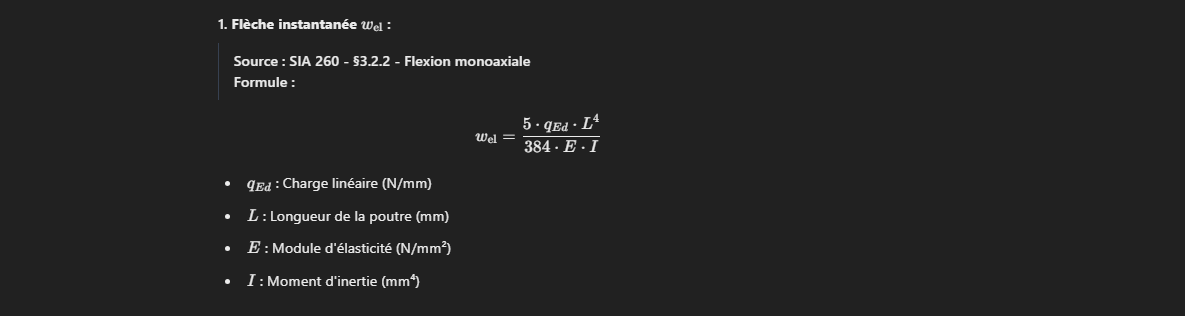
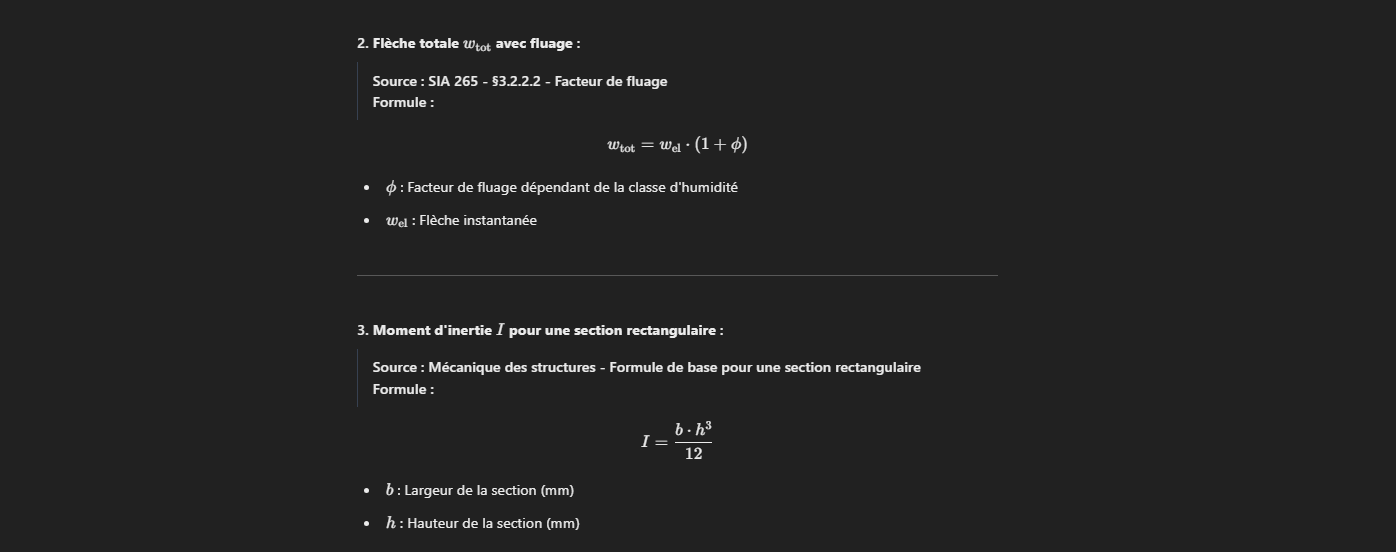
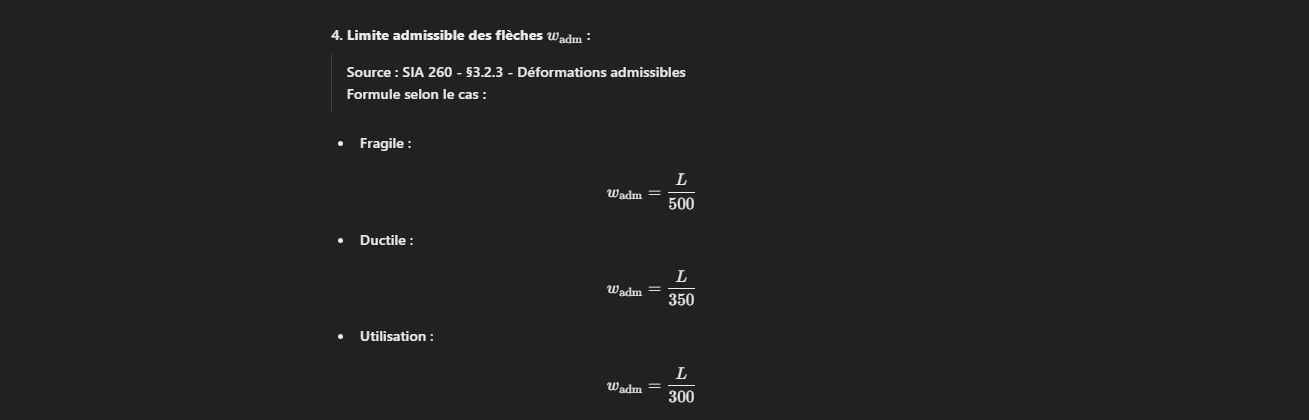
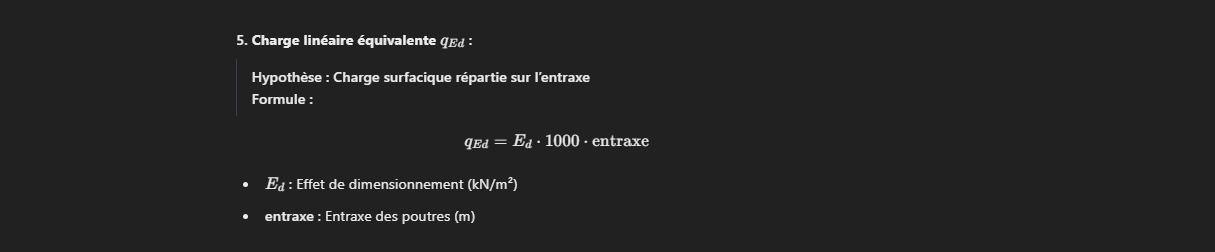
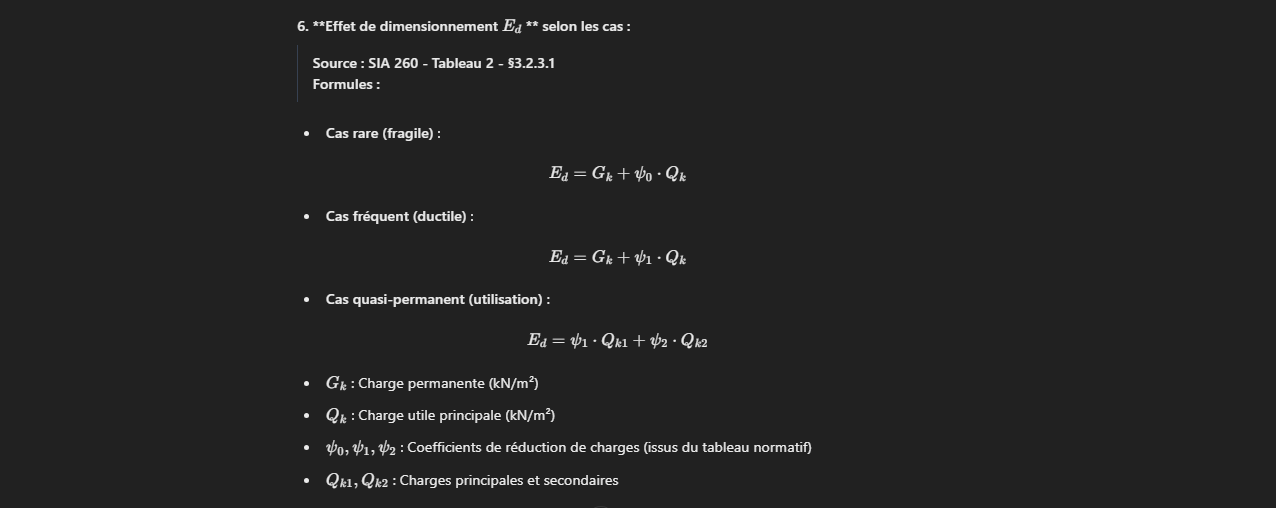
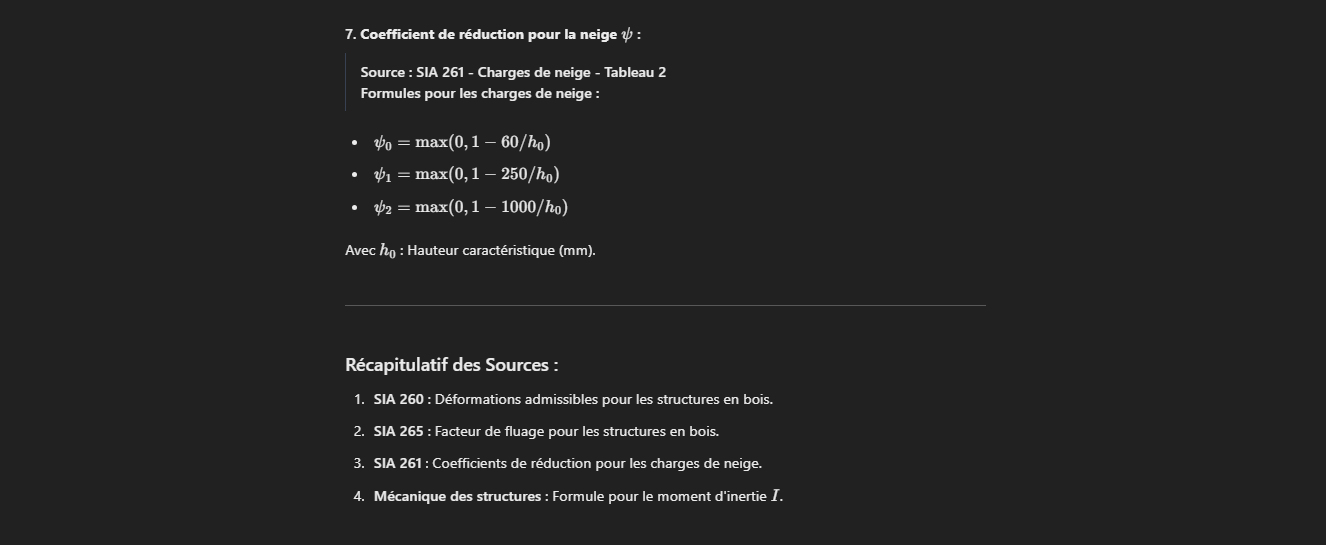

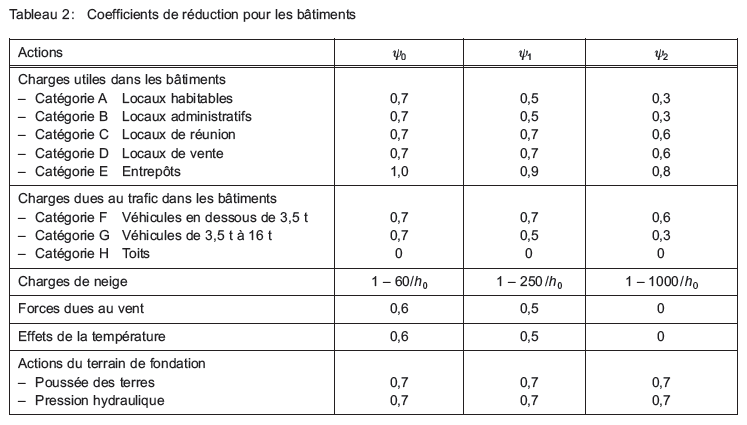


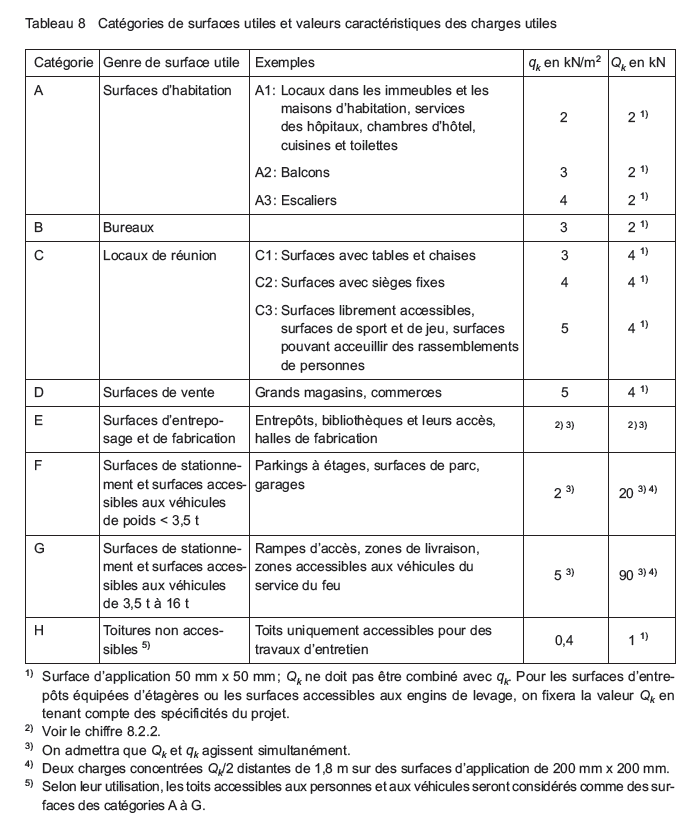

# h min

In [2]:
import math
import pandas as pd

# Fonction de calcul de la flèche instantanée
def calcul_fleche_instantanee(qEd, L, E, I):
    return (5 * qEd * L**4) / (384 * E * I)

# Fonction de calcul de la flèche totale avec fluage
def calcul_fleche_totale(w_el, phi):
    return w_el * (1 + phi)

# Calcul du moment d'inertie pour une section rectangulaire
def calcul_moment_inertie(b, h):
    return (b * h**3) / 12

# Vérification de la flèche admissible
def verif_fleche(w_tot, L, cas):
    limites = {"fragile": L / 500, "ductile": L / 350, "utilisation": L / 300}
    w_adm = limites.get(cas)
    if w_adm is None:
        raise ValueError("Cas invalide. Choisir entre 'fragile', 'ductile' ou 'utilisation'.")
    return w_tot <= w_adm, w_adm

# Création du tableau des résultats
def creer_tableau_resultats(Ed, qEd, w_el, w_tot, w_adm, cas_charge, conforme):
    data = {
        "Paramètres": [
            "Effet de dimensionnement Ed",
            "Charge linéaire qEd",
            "Flèche instantanée",
            "Flèche totale (avec fluage)",
            f"Limite admissible ({cas_charge})",
            "Conformité"
        ],
        "Valeurs": [
            f"{Ed:.2f} kN",
            f"{qEd:.2f} N/mm",
            f"{w_el:.2f} mm",
            f"{w_tot:.2f} mm",
            f"{w_adm:.2f} mm",
            "Conforme" if conforme else "Non conforme"
        ]
    }
    df = pd.DataFrame(data)
    return df

# Fonction pour calculer la hauteur minimale par itération
def calcul_hauteur_min_precise(b, L, qEd, E, cas_charge, phi=0):
    h_min = 1  # Démarrer à 1 mm
    precision = 1  # Incrémenter de 1 mm

    while True:
        I = calcul_moment_inertie(b, h_min)
        w_el = calcul_fleche_instantanee(qEd, L, E, I)
        w_tot = calcul_fleche_totale(w_el, phi)
        conforme, _ = verif_fleche(w_tot, L, cas_charge)
        if conforme:
            break
        h_min += precision

    return h_min

# Calcul des hauteurs minimales précises pour chaque cas de charge
resultats_hauteur_min = {}

for cas in ["fragile", "ductile", "utilisation"]:
    resultats_hauteur_min[cas] = calcul_hauteur_min_precise(b, L, qEd, E, cas, phi)

for cas, h_min in resultats_hauteur_min.items():
    print(f"{cas.capitalize()} - Hauteur minimale précise : {h_min:.2f} mm")


Fragile - Hauteur minimale précise : 265.00 mm
Ductile - Hauteur minimale précise : 236.00 mm
Utilisation - Hauteur minimale précise : 224.00 mm


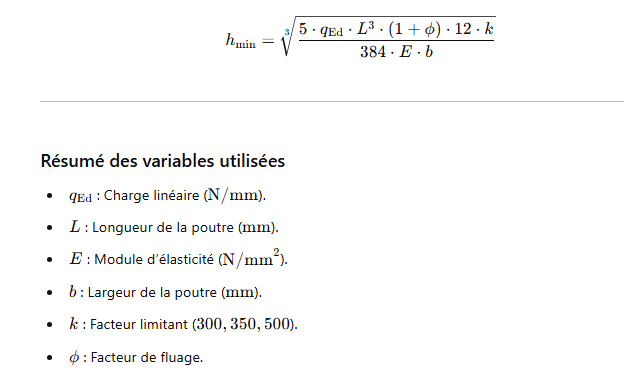